# At Prediction_1 file the non-uniformity coefs map were under research. The following was made
## Basic EDA
## Multioutput prediction for different models
## Different learning approaches were tested among which are:
### Random cell fit where cells were chosen randomly to observe effects on accuracy + chained features collection were considered
### Random cell fit based on graphs where each cell has edges with other cell + chained features collection were considered
### Ordered cell fit when cells were passed it a default order + chained features collection were considered

## As experiments reports the hightes accuracy can be achieved by using Ridge model
## Different training techniques reports almost the same MAE on test dataset but for certain cells there are significant differences

# Highest accuracy is reached by using sklearn in-built Stacking method


In [362]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join('..'))) # imports top level

In [363]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import display
import scipy
from collections import defaultdict

In [364]:
df = pd.read_excel("input.xlsx", sheet_name="no_burnup")

In [365]:
d = display.Display(df=df)
d.quick_processing()

The columns with prefix  are not in DataFrame
The columns with prefix None are not in DataFrame


In [366]:
d.CORE_PARTS.keys()

dict_keys(['default', 'coef', 'left', 'percentage', 'burnup', 'fuel_type', 'index'])

In [367]:
percentage_cols =  d.CORE_PARTS["percentage"]["ALL_CELLS"]
fuel_left_cols = d.CORE_PARTS["left"]["ALL_CELLS"]

In [368]:
d.df

,Name,7-6_s,7-5_s,7-4_s,7-3_s,6-6_s,6-5_s,6-4_s,6-3_s,5-6_s,...,average_t,right_center_side_t,left_center_side_t,right_side_t,left_side_t,center_t,qul_t,qur_t,qll_t,qlr_t
0,121_random_0,1.043046,1.037114,1.117677,1.023991,0.945399,1.227447,1.361819,0.940764,1.031618,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0
1,121_random_1,0.509661,0.808204,0.892903,1.134111,0.669460,1.168714,0.998008,1.052935,1.060237,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0
2,121_random_2,0.993596,0.983636,0.958598,0.823306,0.993841,1.095063,0.756411,1.167815,0.972785,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0
3,121_random_3,0.842348,0.988370,1.126815,0.951305,1.082704,1.171051,1.209545,1.304562,1.250154,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0
4,121_random_4,0.747439,0.913736,1.030984,0.930395,0.760627,1.163903,0.988270,1.025057,1.029310,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,121_random_544,0.670246,0.857544,0.785604,1.072925,0.907801,0.995220,1.162036,1.052018,1.244894,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0
543,121_random_545,0.720889,0.731125,0.802561,1.156266,0.750501,1.269837,1.223177,1.110648,0.940493,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0
544,121_random_546,1.028954,1.033075,0.872344,1.100162,0.981495,1.286540,1.290679,0.997712,1.007821,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0
545,121_random_547,0.594511,1.025157,1.022720,1.014120,1.013433,1.271851,1.294391,1.046027,1.083255,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0


In [369]:
df = d.df

In [370]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, Normalizer, PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, KFold, ShuffleSplit

from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge, RidgeCV, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic


from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    mean_absolute_error, 
    mean_absolute_percentage_error, 
    r2_score, 
    PredictionErrorDisplay
)

from sklearn.base import clone
from collections import Counter

In [371]:
df1 = df.loc[:,
    [
        *d.CORE_PARTS["burnup"]["ALL_CELLS"],
        *d.CORE_PARTS["coef"]["ALL_CELLS"],
        # *percentage_cols,
        *fuel_left_cols,
        # "average_p",
        # "left_side",
        # "center",
        # "right_side",
        # "qur",
        # "qul",
        # "qll",
        # "qlr",
        # "left_side_s",
        # "center_s",
        # "right_side_s",
        # "average",
        # "p, %"
    ]
]

In [372]:
# df_valid = df1.sample(frac=0.1)
# df1 = df1.drop(index=df_valid.index)

In [373]:
df1

,7-6_b,7-5_b,7-4_b,7-3_b,6-6_b,6-5_b,6-4_b,6-3_b,5-6_b,5-3_b,...,4-6_l,4-3_l,3-6_l,3-5_l,3-4_l,3-3_l,2-6_l,2-5_l,2-4_l,2-3_l
0,55.26,87.96,65.64,107.67,97.0165,63.0700,38.7430,134.8850,98.7125,144.39,...,163.26,197.43,179.7230,226.2570,168.3810,183.7510,188.67,145.83,199.05,188.88
1,202.56,135.15,127.32,57.69,151.6860,64.7660,128.1010,116.3350,84.6675,142.92,...,211.44,178.08,136.8990,116.8385,238.8180,152.3750,212.10,212.16,171.72,190.74
2,56.04,87.06,110.49,147.06,84.6940,99.9050,168.1160,67.3365,121.2905,64.23,...,248.19,125.52,214.1995,207.0180,143.8685,152.0835,193.68,215.04,205.77,141.30
3,133.20,111.00,71.64,129.15,54.4045,84.2170,84.9590,49.9260,32.9925,154.62,...,145.38,151.02,184.5460,168.4340,227.4495,166.2875,160.56,125.58,231.72,199.11
4,129.15,86.01,63.51,117.06,124.9210,56.4450,120.3630,114.0825,78.1220,67.23,...,224.10,276.45,161.5175,171.0045,107.1660,234.2335,226.86,240.42,165.30,221.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,151.35,112.29,143.34,48.81,77.1415,100.0375,74.4120,92.3260,0.8215,102.09,...,240.21,230.13,132.8710,205.9580,168.8580,179.0340,235.35,258.48,135.90,222.78
543,135.93,156.69,150.69,43.26,125.7690,16.7215,61.9305,86.4695,108.5970,46.38,...,214.35,176.40,255.4865,137.3495,218.4395,120.6810,230.64,198.42,218.43,205.11
544,54.87,88.11,148.14,81.03,80.6925,40.0945,63.8915,123.9405,105.8145,133.56,...,115.11,243.12,215.6570,224.1105,136.4485,173.2040,215.58,180.42,192.15,144.57
545,187.98,73.32,87.03,103.05,65.1370,27.4540,48.4155,106.8480,78.7845,87.24,...,214.71,158.13,237.4135,174.9795,167.7715,190.1110,206.46,190.71,167.13,177.78


In [374]:
y1 = df1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"][0]]
X_raw1 = df1.drop(
    d.CORE_PARTS["coef"]["ALL_CELLS"],
    axis=1
)

In [375]:
ct_c_test = ColumnTransformer(
    [
        # ("row1", Normalizer(), X_raw1.columns[:20]),
        # ("row2", Normalizer(), X_raw1.columns[20:]),
        
        ("row11", Normalizer(), X_raw1.columns[:4]),
        ("row12", Normalizer(), X_raw1.columns[4:8]),
        ("row13", Normalizer(), X_raw1.columns[8:12]),
        ("row14", Normalizer(), X_raw1.columns[12:16]),
        ("row15", Normalizer(), X_raw1.columns[16:20]),

        ("row21", Normalizer(), X_raw1.columns[20:24]),
        ("row22", Normalizer(), X_raw1.columns[24:28]),
        ("row23", Normalizer(), X_raw1.columns[28:32]),
        ("row24", Normalizer(), X_raw1.columns[32:36]),
        ("row25", Normalizer(), X_raw1.columns[36:40]),
    ]
).set_output(transform="pandas")

In [376]:
X1_test = ct_c_test.fit_transform(X_raw1)

In [377]:
X_traint1, X_testt1, y_traint1, y_testt1 = train_test_split(X1_test, y1, random_state=42, test_size=0.2)

In [378]:
ridget1 = Ridge().fit(X_traint1, y_traint1)

In [379]:
y_pred_ridget1 = ridget1.predict(X_testt1)

In [380]:
mean_absolute_error(
    y_pred_ridget1,
    y_testt1
)

0.07114021995269963

In [381]:
ct_c = ColumnTransformer(
    [
        ("", StandardScaler(), X_raw1.columns)
    ],
    remainder="drop"
).set_output(transform="pandas")

In [382]:
X1 = ct_c.fit_transform(X_raw1)

In [383]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=42, test_size=0.2)

In [384]:
cross_val_score(Ridge(), X1, y1, cv=3, scoring="neg_mean_absolute_error")

array([-0.01223933, -0.0122537 , -0.01243356])

In [385]:
ridge1 = Ridge().fit(X_train1, y_train1)

In [386]:
y_pred_ridge1 = ridge1.predict(X_test1)

Text(0.5, 1.0, 'Just quick view on Predictive power of Ridge')

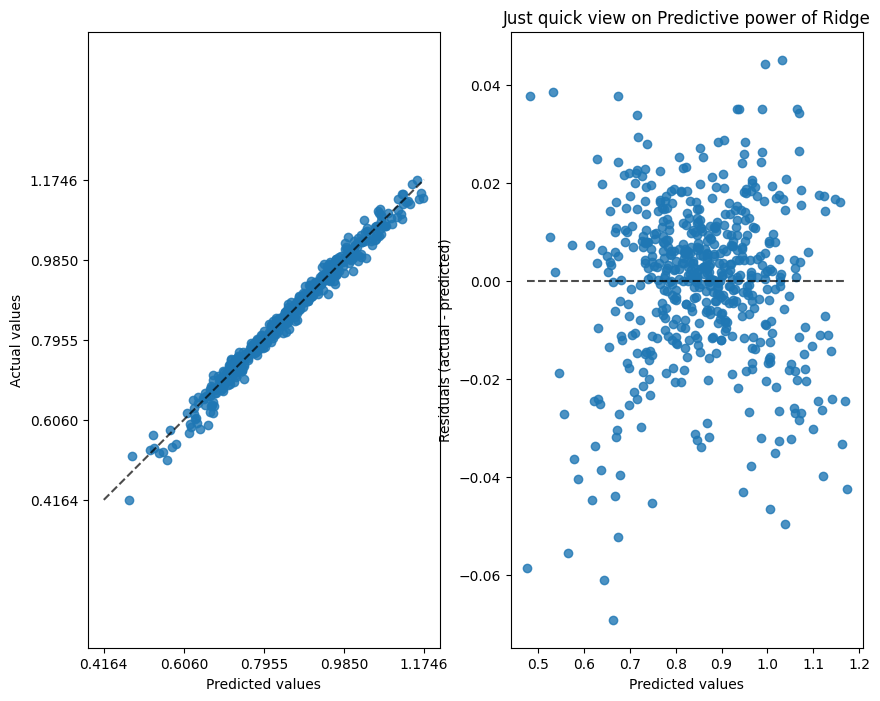

In [387]:
fig, axs = plt.subplots(1,2, figsize=(10,8))
PredictionErrorDisplay.from_predictions(
    y1,
    y_pred=cross_val_predict(Ridge(), X1, y1, cv=3),
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=42,
)
PredictionErrorDisplay.from_predictions(
    y1,
    y_pred=cross_val_predict(Ridge(), X1, y1, cv=3),
    kind="residual_vs_predicted",
    ax=axs[1],
    random_state=42,
)
plt.title("Just quick view on Predictive power of Ridge")


In [388]:
y_pred_ridge1

array([0.80013045, 0.95144667, 0.78341856, 0.86820702, 0.76668307,
       0.63936316, 0.76919433, 0.93700299, 0.94545439, 0.70409283,
       1.05677   , 0.85996342, 1.09804401, 0.93375288, 0.67818556,
       0.77398627, 0.79326325, 0.75185666, 1.13537038, 0.84288115,
       0.90376526, 0.94907228, 0.71839194, 0.92588235, 1.1403153 ,
       0.9982567 , 0.73089467, 0.89421736, 0.95725826, 1.07088943,
       0.8437796 , 0.87568165, 0.88706116, 0.8498999 , 0.7767821 ,
       0.82853876, 0.77484301, 0.80477811, 1.09767782, 0.76086878,
       0.77039931, 0.88746294, 0.83305866, 0.82234514, 0.96561262,
       0.81909234, 0.84470644, 0.78227559, 0.76622242, 0.65691305,
       1.01981719, 0.96545228, 1.00938127, 0.70796857, 0.93698747,
       1.02022374, 0.87012045, 0.82706999, 0.91442335, 0.7316588 ,
       0.84753798, 1.04067204, 0.86902437, 0.78461135, 0.7255961 ,
       0.86330416, 0.77261533, 0.67849487, 0.8461861 , 0.77046733,
       0.64909006, 0.61235206, 0.67924776, 0.84476504, 0.66704

In [389]:
mean_absolute_error(
    y_pred_ridge1,
    y_test1
)

0.01201874077388437

In [390]:
y_mo = df1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]

# rch_order = [ 4,  5,  6,  7,  1,  3,  8,  9,  0, 10,  2, 11, 19, 18, 14, 12, 17,
#         16, 15, 13]

# rch_order =  [
#     '7-6_s',
#     '7-5_s',
#     '6-6_s',
#     '6-5_s',
#     '7-4_s',
#     '7-3_s',
#     '6-4_s',
#     '6-3_s',
#     '5-3_s',
#     '4-3_s',
#     '3-3_s',
#     '3-4_s',
#     '2-3_s',
#     '2-4_s',
#     '2-5_s',
#     '2-6_s',
#     '3-5_s',
#     '3-6_s',
#     '4-6_s',
#     '5-6_s'
# ]
# # y_mo = y_mo.reindex(columns=y_mo.columns[rch_order])
# y_mo = y_mo.reindex(columns=rch_order)

X_mo_raw = df1.drop(
    d.CORE_PARTS["coef"]["ALL_CELLS"],
    axis=1
)

In [391]:
y_mo.columns

Index(['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-6_s', '6-5_s', '6-4_s', '6-3_s',
       '5-6_s', '5-3_s', '4-6_s', '4-3_s', '3-6_s', '3-5_s', '3-4_s', '3-3_s',
       '2-6_s', '2-5_s', '2-4_s', '2-3_s'],
      dtype='object')

In [392]:
ct_mo = ColumnTransformer(
    [
        ("", StandardScaler(), X_mo_raw.columns)
    ],
    remainder="passthrough"
).set_output(transform="pandas")

In [393]:
X_mo = ct_mo.fit_transform( X_mo_raw)

In [394]:
X_train_mo, X_test_mo, y_train_mo, y_test_mo = train_test_split(X_mo, y_mo, random_state=50, test_size=0.2)

## Trying in-built Regressor Chain

In [395]:

mo_ridge = MultiOutputRegressor(Ridge(random_state=42)).fit(X_train_mo, y_train_mo)
rch_ridge = RegressorChain(
    Ridge(random_state=42), 
    random_state=42, 
).fit(X_train_mo, y_train_mo)

In [396]:
mo_ridge_cells = defaultdict(list)
rch_ridge_cells = defaultdict(list)

for i in range(y_mo.shape[1]):
    test_array = X_test_mo.to_numpy()
    y_step = y_test_mo[y_test_mo.columns[i]]
    print("Predictable :", y_test_mo.columns[i])
    print(mo_ridge.estimators_[i].score(X_test_mo, y_step), end=" ")
    print(rch_ridge.estimators_[i].score(pd.concat([X_test_mo, y_test_mo[y_test_mo.columns[:i]]], axis=1), y_step))
    # print(mo_ridge.estimators_[i].coef_, end=" ")
    

    mo_mea = mean_absolute_error(
            mo_ridge.estimators_[i].predict(X_test_mo),
            y_step
        )

    mo_ridge_cells[y_test_mo.columns[i]].append(
        mo_mea
    )
    print(
        "MAE:", mo_mea
    )

    rch_mea = mean_absolute_error(
        rch_ridge.estimators_[i].predict(pd.concat([X_test_mo, y_test_mo[y_test_mo.columns[:i]]], axis=1)),
        y_step    
    )
    
    rch_ridge_cells[y_test_mo.columns[i]].append(
        rch_mea
    )
    print(
        "MAE:", rch_mea
    )

Predictable : 7-6_s
0.9807241886118987 0.9807241886118987
MAE: 0.013338472443955654
MAE: 0.013338472443955654
Predictable : 7-5_s
0.9871427979883981 0.9878767110879637
MAE: 0.01090961825254053
MAE: 0.010601075091796428
Predictable : 7-4_s
0.9774296944173864 0.9781544057593012
MAE: 0.015641116071486858
MAE: 0.015297339374046011
Predictable : 7-3_s
0.9854665784653011 0.9863991120602731
MAE: 0.012589371356435692
MAE: 0.01213638128538701
Predictable : 6-6_s
0.9855211632827329 0.9864456070473322
MAE: 0.011161132980198333
MAE: 0.010745516380552001
Predictable : 6-5_s
0.9835079402692685 0.9854549413923931
MAE: 0.01346353826430813
MAE: 0.012565173099107416
Predictable : 6-4_s
0.9816523137573138 0.9824824677672557
MAE: 0.015063376228779032
MAE: 0.014582092353131184
Predictable : 6-3_s
0.9836346408087313 0.9847386079065317
MAE: 0.013434111768941175
MAE: 0.012944459266273882
Predictable : 5-6_s
0.984292846765656 0.9846207192920338
MAE: 0.013115848408666501
MAE: 0.012931919071659215
Predictable : 

/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but Ridge was fitted without feature names
  

In [397]:
mo_ridge_cells, rch_ridge_cells

(defaultdict(list,
             {'7-6_s': [0.013338472443955654],
              '7-5_s': [0.01090961825254053],
              '7-4_s': [0.015641116071486858],
              '7-3_s': [0.012589371356435692],
              '6-6_s': [0.011161132980198333],
              '6-5_s': [0.01346353826430813],
              '6-4_s': [0.015063376228779032],
              '6-3_s': [0.013434111768941175],
              '5-6_s': [0.013115848408666501],
              '5-3_s': [0.014609518358132737],
              '4-6_s': [0.010626432401899562],
              '4-3_s': [0.01207526557608783],
              '3-6_s': [0.012497742386137106],
              '3-5_s': [0.012399612138768128],
              '3-4_s': [0.015860245150408507],
              '3-3_s': [0.01583574511712722],
              '2-6_s': [0.01126530581419436],
              '2-5_s': [0.012891467462436176],
              '2-4_s': [0.010772220789589447],
              '2-3_s': [0.012467601915494038]}),
 defaultdict(list,
             {'7-6_s': [0

In [398]:
y_pred_mo = mo_ridge.predict(X_test_mo)
y_pred_rch = rch_ridge.predict(X_test_mo)

In [399]:
mean_absolute_error(
    y_pred_mo,
    y_test_mo
), mean_absolute_error(
    y_pred_rch,
    y_test_mo
)

(0.013000887144279352, 0.013000887144279352)

### Some piece of statistical stuff on RCH predictions 

Text(0.5, 1.0, 'Just quick view on Predictive power of Regression chain with Ridge')

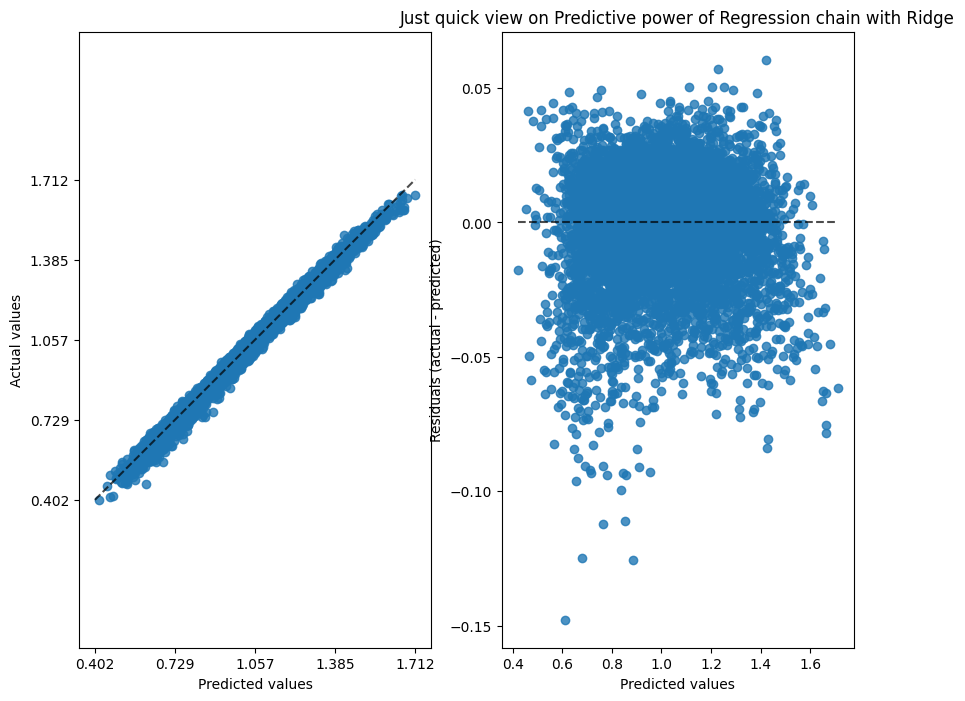

In [400]:
fig, axs = plt.subplots(1,2, figsize=(10,8))
PredictionErrorDisplay.from_predictions(
    y_mo,
    y_pred=cross_val_predict(RegressorChain(Ridge()), X_mo, y_mo, cv=3),
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=42,
)
PredictionErrorDisplay.from_predictions(
    y_mo,
    y_pred=cross_val_predict(RegressorChain(Ridge()), X_mo, y_mo, cv=3),
    kind="residual_vs_predicted",
    ax=axs[1],
    random_state=42,
)
plt.title("Just quick view on Predictive power of Regression chain with Ridge")


In [401]:
#average interval of prediction
rch_mo_intervals = ( ( ( ((y_pred_rch - y_test_mo)**2).sum() / ( len(y_test_mo) - 2) )**(1/2) )  * 1.96 ).to_numpy()
rch_mo_intervals, rch_mo_intervals.mean() 

(array([0.03406217, 0.02924831, 0.04347329, 0.03231245, 0.0305802 ,
        0.03554604, 0.04302183, 0.03718505, 0.03291483, 0.03866112,
        0.02926851, 0.03455722, 0.03434644, 0.03360151, 0.04475865,
        0.04856863, 0.03024231, 0.03517114, 0.02882946, 0.03310548]),
 0.0354727318637604)

<Axes: xlabel='457', ylabel='457'>

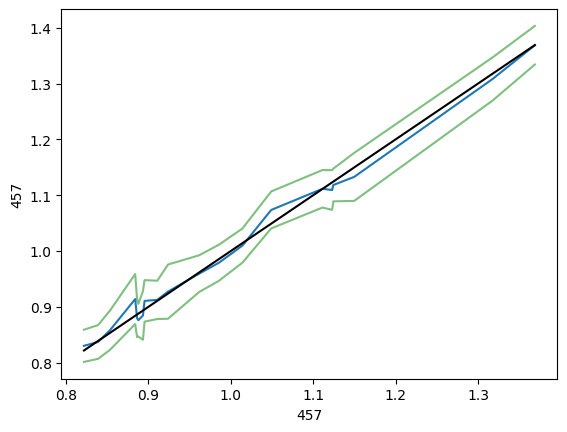

In [402]:
fig, ax = plt.subplots()

rch_mo_int_lower = y_pred_rch - rch_mo_intervals
rch_mo_int_upper = y_pred_rch + rch_mo_intervals

sns.lineplot(x=y_test_mo.iloc[0], y=y_pred_rch[0, :], ax=ax)
sns.lineplot(x=y_test_mo.iloc[0], y=y_test_mo.iloc[0], ax=ax, color="black")
sns.lineplot(x=y_test_mo.iloc[0], y=rch_mo_int_lower[0, :], ax=ax, color="green", alpha=0.5) 
sns.lineplot(x=y_test_mo.iloc[0], y=rch_mo_int_upper[0, :], ax=ax, color="green", alpha=0.5)

# ax.fill_between(y_test_mo["7-6_s"], rch_mo_int_lower, rch_mo_int_upper, alpha=0.2)


In [403]:
d.display(y_test_mo.iloc[0].to_numpy(), dt="_s")

,6,5,4,3
7,0.886207,0.887784,0.893330,0.985673
6,1.014046,1.122930,1.149745,0.895313
5,0.961422,nan,nan,1.317526
4,1.124386,nan,nan,1.368952
3,0.910778,1.111217,0.883927,0.923807
2,0.838883,0.853320,0.821744,1.049010


In [404]:
d.display(y_pred_rch[0], dt="_s")

,6,5,4,3
7,0.879821,0.876061,0.884464,0.979081
6,1.009686,1.109293,1.132825,0.910610
5,0.959306,nan,nan,1.308059
4,1.118219,nan,nan,1.368708
3,0.912447,1.111461,0.913884,0.927266
2,0.837089,0.858042,0.830109,1.073569


# Lets try to do some ensembles like moves

In [405]:
# errors_storage_str_stck_bag,  scores_storage_str_stck_bag, models_str_stck_bag, val_stck_bag, order_str_stck_bag = straight_stacking_bagging(
#     display.Display().CORE_PARTS["coef"]["ALL_CELLS"].copy(),
#     df1,
#     estimators=bms,
#     meta_estimator=mm,
#     iter_times=4,
# )

In [406]:
df1 = df.loc[:,
    [
        *d.CORE_PARTS["burnup"]["ALL_CELLS"],
        *d.CORE_PARTS["coef"]["ALL_CELLS"],
        *fuel_left_cols,
    ]
]

In [407]:
from regression.stacking import Stacking

In [408]:
kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-5, 1e1)) + RationalQuadratic()

bm1 = ("gbr", GradientBoostingRegressor(n_estimators=500))
bm2 = ("bridge", BayesianRidge())
bm3 = ("sgdr", SGDRegressor())

# bm4 = ("rfr", RandomForestRegressor(n_estimators=500))

mm = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
# mm = RidgeCV()

st = Stacking(
    base_estimators=[
        # bm1, 
        bm2, 
        bm3, 
        # bm4
        # bm5
    ],
    meta_estimator=mm
)

In [409]:
df1_val = df1.sample(frac=0.20)
df1 = df1.drop(index=df1_val.index).reset_index().drop("index", axis=1)

In [410]:
X_st_raw = df1.loc[
    :,
    [
        *d.CORE_PARTS["burnup"]["ALL_CELLS"],
        *fuel_left_cols,
    ]
]
y_st = df1.loc[
    :,
    d.CORE_PARTS["coef"]["ALL_CELLS"]
]

In [411]:
st_model, st_errors = st.make_model(
    X_raw = X_st_raw,
    y=y_st
)

      __7-6_b   __7-5_b   __7-4_b   __7-3_b   __6-6_b   __6-5_b   __6-4_b  \
0    2.555348  0.862733  0.565069 -1.205119  1.779432 -0.819467  1.168177   
1    0.743193  0.225564 -0.853083  0.722963 -1.099099 -0.197779 -0.146299   
2    0.637380 -0.433768 -1.060151  0.396760  0.987463 -1.085421  0.932411   
3   -1.694438  2.923837  0.607858  0.544887 -0.791721 -0.038546  1.606606   
4   -0.641789 -0.327705 -1.664547  0.637163 -1.130464 -1.758776 -0.379643   
..        ...       ...       ...       ...       ...       ...       ...   
433  1.217395  0.259599  0.973094 -1.444712 -0.426318  0.307872 -0.467652   
434  0.814519  1.431040  1.160296 -1.594458  1.012555 -2.355054 -0.847946   
435 -1.303320 -0.378362  1.095348 -0.575376 -0.321245 -1.608012 -0.788197   
436  2.174419 -0.768579 -0.461104  0.018752 -0.781528 -2.012025 -1.259729   
437  0.930522  1.109685 -0.730064  0.037369 -0.622350  0.755081  1.923921   

      __6-3_b   __5-6_b   __5-3_b  ...   __3-6_l   __3-5_l   __3-4_l  \
0  

/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


MAE 0.006017309307405753
MSE 5.7772573569672906e-05
R2 0.996962297917184
      __7-6_b   __7-5_b   __7-4_b   __7-3_b   __6-6_b   __6-5_b   __6-4_b  \
0    2.555348  0.862733  0.565069 -1.205119  1.779432 -0.819467  1.168177   
1    0.743193  0.225564 -0.853083  0.722963 -1.099099 -0.197779 -0.146299   
2    0.637380 -0.433768 -1.060151  0.396760  0.987463 -1.085421  0.932411   
3   -1.694438  2.923837  0.607858  0.544887 -0.791721 -0.038546  1.606606   
4   -0.641789 -0.327705 -1.664547  0.637163 -1.130464 -1.758776 -0.379643   
..        ...       ...       ...       ...       ...       ...       ...   
433  1.217395  0.259599  0.973094 -1.444712 -0.426318  0.307872 -0.467652   
434  0.814519  1.431040  1.160296 -1.594458  1.012555 -2.355054 -0.847946   
435 -1.303320 -0.378362  1.095348 -0.575376 -0.321245 -1.608012 -0.788197   
436  2.174419 -0.768579 -0.461104  0.018752 -0.781528 -2.012025 -1.259729   
437  0.930522  1.109685 -0.730064  0.037369 -0.622350  0.755081  1.923921   

  

/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


MAE 0.006394581373044246
MSE 6.660420543134078e-05
R2 0.996844750771258
      __7-6_b   __7-5_b   __7-4_b   __7-3_b   __6-6_b   __6-5_b   __6-4_b  \
0    2.555348  0.862733  0.565069 -1.205119  1.779432 -0.819467  1.168177   
1    0.743193  0.225564 -0.853083  0.722963 -1.099099 -0.197779 -0.146299   
2    0.637380 -0.433768 -1.060151  0.396760  0.987463 -1.085421  0.932411   
3   -1.694438  2.923837  0.607858  0.544887 -0.791721 -0.038546  1.606606   
4   -0.641789 -0.327705 -1.664547  0.637163 -1.130464 -1.758776 -0.379643   
..        ...       ...       ...       ...       ...       ...       ...   
433  1.217395  0.259599  0.973094 -1.444712 -0.426318  0.307872 -0.467652   
434  0.814519  1.431040  1.160296 -1.594458  1.012555 -2.355054 -0.847946   
435 -1.303320 -0.378362  1.095348 -0.575376 -0.321245 -1.608012 -0.788197   
436  2.174419 -0.768579 -0.461104  0.018752 -0.781528 -2.012025 -1.259729   
437  0.930522  1.109685 -0.730064  0.037369 -0.622350  0.755081  1.923921   

   

/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


MAE 0.005434063946725541
MSE 5.0984004668768246e-05
R2 0.9979045824446487
      __7-6_b   __7-5_b   __7-4_b   __7-3_b   __6-6_b   __6-5_b   __6-4_b  \
0    2.555348  0.862733  0.565069 -1.205119  1.779432 -0.819467  1.168177   
1    0.743193  0.225564 -0.853083  0.722963 -1.099099 -0.197779 -0.146299   
2    0.637380 -0.433768 -1.060151  0.396760  0.987463 -1.085421  0.932411   
3   -1.694438  2.923837  0.607858  0.544887 -0.791721 -0.038546  1.606606   
4   -0.641789 -0.327705 -1.664547  0.637163 -1.130464 -1.758776 -0.379643   
..        ...       ...       ...       ...       ...       ...       ...   
433  1.217395  0.259599  0.973094 -1.444712 -0.426318  0.307872 -0.467652   
434  0.814519  1.431040  1.160296 -1.594458  1.012555 -2.355054 -0.847946   
435 -1.303320 -0.378362  1.095348 -0.575376 -0.321245 -1.608012 -0.788197   
436  2.174419 -0.768579 -0.461104  0.018752 -0.781528 -2.012025 -1.259729   
437  0.930522  1.109685 -0.730064  0.037369 -0.622350  0.755081  1.923921   

 

/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


MAE 0.006225487396947795
MSE 6.723627130203538e-05
R2 0.9967242216396323
      __7-6_b   __7-5_b   __7-4_b   __7-3_b   __6-6_b   __6-5_b   __6-4_b  \
0    2.555348  0.862733  0.565069 -1.205119  1.779432 -0.819467  1.168177   
1    0.743193  0.225564 -0.853083  0.722963 -1.099099 -0.197779 -0.146299   
2    0.637380 -0.433768 -1.060151  0.396760  0.987463 -1.085421  0.932411   
3   -1.694438  2.923837  0.607858  0.544887 -0.791721 -0.038546  1.606606   
4   -0.641789 -0.327705 -1.664547  0.637163 -1.130464 -1.758776 -0.379643   
..        ...       ...       ...       ...       ...       ...       ...   
433  1.217395  0.259599  0.973094 -1.444712 -0.426318  0.307872 -0.467652   
434  0.814519  1.431040  1.160296 -1.594458  1.012555 -2.355054 -0.847946   
435 -1.303320 -0.378362  1.095348 -0.575376 -0.321245 -1.608012 -0.788197   
436  2.174419 -0.768579 -0.461104  0.018752 -0.781528 -2.012025 -1.259729   
437  0.930522  1.109685 -0.730064  0.037369 -0.622350  0.755081  1.923921   

  

In [412]:
X_st_val = df1_val.loc[
    :,
    [
        *d.CORE_PARTS["burnup"]["ALL_CELLS"],
        *fuel_left_cols,
    ]
]
y_st_val = df1_val.loc[
    :,
    d.CORE_PARTS["coef"]["ALL_CELLS"]
]

In [413]:

res_st = st.predict(X_st_val, st_model)
res_st00 = st.predict(X_st_raw, st_model)
res_st

,7-6_s,7-5_s,7-4_s,7-3_s,6-6_s,6-5_s,6-4_s,6-3_s,5-6_s,5-3_s,4-6_s,4-3_s,3-6_s,3-5_s,3-4_s,3-3_s,2-6_s,2-5_s,2-4_s,2-3_s
0,1.010384,1.042276,1.116363,1.180059,1.264267,1.199411,1.289544,1.171711,1.199935,1.027108,1.010083,0.920679,0.739690,1.018232,0.750450,1.097564,0.765298,0.706457,0.691328,0.787247
1,0.793486,0.887099,0.870363,0.784780,0.835553,0.927066,1.060751,0.945875,1.131289,1.080861,1.115432,1.289130,0.979212,1.021139,1.380385,1.037865,0.999010,1.073077,0.984728,0.806585
2,0.787187,0.894765,0.872920,0.930447,1.143909,0.986265,1.143293,1.002415,1.095826,1.263784,1.249498,1.195917,0.879722,0.884422,1.128214,1.125689,0.850841,0.747769,0.910655,0.915205
3,0.913738,0.971916,0.954353,1.101175,1.014872,1.254830,1.262197,1.041174,0.925860,1.438954,0.946927,1.406111,0.899189,0.723168,1.058440,0.999349,0.727078,0.725027,0.793996,0.847808
4,0.827377,0.904269,1.036966,1.113454,0.938886,1.125221,1.311393,1.276238,1.049331,1.176945,0.733788,1.449102,0.933544,0.799652,0.824358,1.047328,0.796044,0.830831,1.045543,0.781580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,0.839110,1.048126,1.130028,1.093549,0.870106,1.377058,0.672605,1.324500,1.068650,1.164423,1.205017,1.329079,0.963967,0.937969,0.881044,1.014398,0.759489,0.835194,0.841810,0.643239
105,0.865863,0.857945,0.904766,0.857003,0.844088,1.186902,1.175387,1.032776,1.051729,1.170485,1.026538,1.487386,0.691990,0.946725,1.166038,1.338904,0.807665,0.870207,0.846802,0.878864
106,0.760155,0.996166,1.081388,1.078371,1.120379,1.167725,1.008256,1.155825,1.064071,1.372637,1.098598,1.192650,0.847713,0.964788,0.907736,0.917535,0.796487,0.826812,0.825384,0.822693
107,0.689253,0.663212,0.813670,0.708983,0.897327,0.941949,0.849115,1.097992,0.928883,1.286347,1.168553,1.199917,0.938001,1.349936,1.332439,1.341770,0.799558,1.011405,1.043849,0.944106


In [414]:
ct_mo = ColumnTransformer(
    [
        ("", StandardScaler(), X_st_raw.columns)
    ],
    remainder="passthrough"
).set_output(transform="pandas")

In [415]:
gpr = MultiOutputRegressor(
    GaussianProcessRegressor(kernel=kernel, alpha=0.0)
)
X = ct_mo.fit_transform(X_st_raw)
gpr.fit(X,y_st)
y_gpr_mo = gpr.predict(
    ct_mo.transform(X_st_val)
)

/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [416]:
mean_absolute_error(
    y_gpr_mo,
    y_st_val
)

0.005186357147665023

In [417]:
d.display(data=df.loc[3, [*d.CORE_PARTS["coef"]["ALL_CELLS"]]], dt="_s")

,6,5,4,3
7,0.842348,0.988370,1.126815,0.951305
6,1.082704,1.171051,1.209545,1.304562
5,1.250154,nan,nan,1.070562
4,0.841696,nan,nan,1.044775
3,0.901943,0.967335,1.180633,0.974000
2,0.677747,0.617497,0.922652,0.874306


In [418]:
d.display(data=df.loc[5, [*d.CORE_PARTS["coef"]["ALL_CELLS"]]], dt="_s")

,6,5,4,3
7,0.711179,0.895369,0.875058,0.820884
6,1.021477,0.945070,1.038629,1.184745
5,1.097646,nan,nan,1.345248
4,1.240703,nan,nan,0.987450
3,0.977888,0.969851,1.222798,1.031677
2,1.009614,0.844466,0.978253,0.801996


In [419]:
pr = st.predict(df.loc[[3,5], :], st_model)

In [420]:
d.display(data=pr.loc[0, :], dt="_s")


,6,5,4,3
7,0.842015,0.974147,1.125098,0.940827
6,1.082686,1.170433,1.193164,1.302564
5,1.250196,nan,nan,1.068778
4,0.842055,nan,nan,1.058796
3,0.901673,0.966632,1.179593,0.981285
2,0.679134,0.622933,0.923051,0.878064


In [421]:
d.display(data=pr.loc[1, :], dt="_s")

,6,5,4,3
7,0.726151,0.904172,0.878908,0.833119
6,1.020702,0.958653,1.035015,1.197421
5,1.100311,nan,nan,1.358992
4,1.234877,nan,nan,0.991810
3,0.964862,0.970473,1.214469,1.023705
2,0.992969,0.830657,0.965717,0.799020


In [422]:
st_errors[0]["means"], st_errors

({'MAE': 0.0059086641693927655,
  'MSE': 5.9137968721744944e-05,
  'R2': 0.9968345746112609},
 {0: {'7-6_s': {'MAE': 0.005623161017732543,
    'MSE': 5.534988171510287e-05,
    'R2': 0.9966767643480607},
   '7-5_s': {'MAE': 0.006306874965894465,
    'MSE': 6.831591156855653e-05,
    'R2': 0.9962476180493292},
   '7-4_s': {'MAE': 0.00630292756690209,
    'MSE': 6.717138712932663e-05,
    'R2': 0.9966835321988455},
   '7-3_s': {'MAE': 0.006624016472548597,
    'MSE': 7.176874396456421e-05,
    'R2': 0.9965492121560717},
   '6-6_s': {'MAE': 0.005438844644079923,
    'MSE': 4.9164440527603036e-05,
    'R2': 0.9971812690933395},
   '6-5_s': {'MAE': 0.006017309307405753,
    'MSE': 5.7772573569672906e-05,
    'R2': 0.996962297917184},
   '6-4_s': {'MAE': 0.0065922593191036615,
    'MSE': 8.150597853645815e-05,
    'R2': 0.9962948332961274},
   '6-3_s': {'MAE': 0.006394581373044246,
    'MSE': 6.660420543134078e-05,
    'R2': 0.996844750771258},
   '5-6_s': {'MAE': 0.005287305157645476,
    '

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, '7-6_s'),
  Text(1, 0, '7-5_s'),
  Text(2, 0, '7-4_s'),
  Text(3, 0, '7-3_s'),
  Text(4, 0, '6-6_s'),
  Text(5, 0, '6-5_s'),
  Text(6, 0, '6-4_s'),
  Text(7, 0, '6-3_s'),
  Text(8, 0, '5-6_s'),
  Text(9, 0, '5-3_s'),
  Text(10, 0, '4-6_s'),
  Text(11, 0, '4-3_s'),
  Text(12, 0, '3-6_s'),
  Text(13, 0, '3-5_s'),
  Text(14, 0, '3-4_s'),
  Text(15, 0, '3-3_s'),
  Text(16, 0, '2-6_s'),
  Text(17, 0, '2-5_s'),
  Text(18, 0, '2-4_s'),
  Text(19, 0, '2-3_s'),
  Text(20, 0, 'means')])

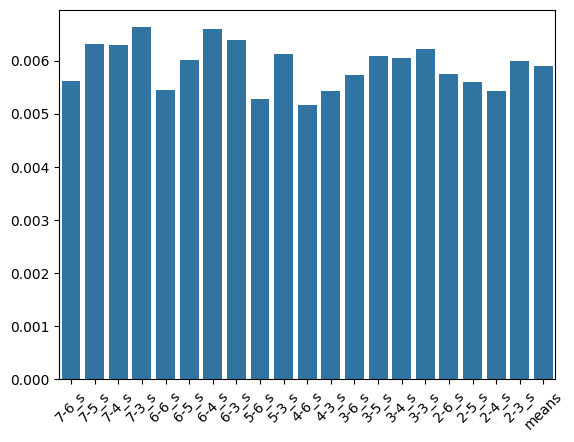

In [423]:
# errors by cells
mae = []
for i in st_errors[0].values():
    mae.append(i["MAE"])
sns.barplot(x=st_errors[0].keys(), y=mae)
plt.xticks(rotation=45)

[0.0137949  0.01496945 0.01673    0.01600085 0.01238952 0.01546067
 0.0194229  0.01431868 0.01507588 0.0172927  0.01154297 0.01547252
 0.01532406 0.01733582 0.01540177 0.01290327 0.01273546 0.0156416
 0.01563881 0.01504096] 0.015124639326548278
[0.01210022 0.01265094 0.0133435  0.01352147 0.01238266 0.01293015
 0.01390613 0.01362227 0.01214558 0.01481957 0.01162449 0.01462504
 0.0117724  0.01288845 0.01367518 0.01343259 0.01096004 0.01205016
 0.01182016 0.01262454] 0.012844776946800685


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, '7-6_s'),
  Text(1, 0, '7-5_s'),
  Text(2, 0, '7-4_s'),
  Text(3, 0, '7-3_s'),
  Text(4, 0, '6-6_s'),
  Text(5, 0, '6-5_s'),
  Text(6, 0, '6-4_s'),
  Text(7, 0, '6-3_s'),
  Text(8, 0, '5-6_s'),
  Text(9, 0, '5-3_s'),
  Text(10, 0, '4-6_s'),
  Text(11, 0, '4-3_s'),
  Text(12, 0, '3-6_s'),
  Text(13, 0, '3-5_s'),
  Text(14, 0, '3-4_s'),
  Text(15, 0, '3-3_s'),
  Text(16, 0, '2-6_s'),
  Text(17, 0, '2-5_s'),
  Text(18, 0, '2-4_s'),
  Text(19, 0, '2-3_s'),
  Text(20, 0, 'means')])

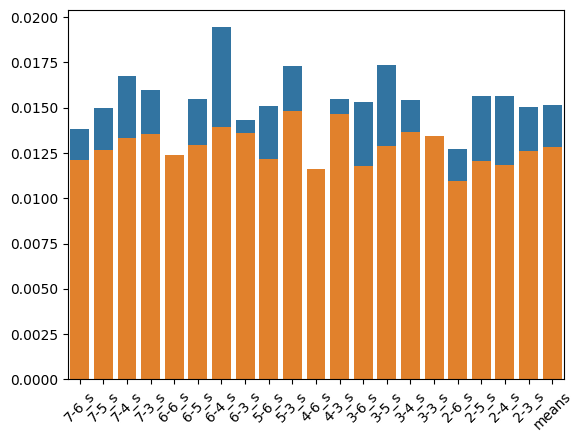

In [424]:
  

#average interval of prediction
st_pred_intervals = ( ( ( ( (res_st.to_numpy() - y_st_val)**2).sum() / ( len(y_st_val) - 2) )**(1/2) )  * 1.96 ).to_numpy()
print(st_pred_intervals, st_pred_intervals.mean())

st_con_intervals = ( 1.96*y_st.std(axis=0) / np.sqrt(len(y_st)) ).to_numpy()
print(st_con_intervals, st_con_intervals.mean())

sns.barplot(x=st_errors[0].keys(), y=[*st_pred_intervals, st_pred_intervals.mean()])
sns.barplot(x=st_errors[0].keys(), y=[*st_con_intervals, st_con_intervals.mean()])
plt.xticks(rotation=45)

In [425]:
from joblib import dump
dump(filename="new_stack_unifor_v1.5.joblib", value=st_model)

['new_stack_unifor_v1.5.joblib']

In [126]:
m1 = ("gbr", GradientBoostingRegressor(n_estimators=100), True)
m2 = ("bridge", BayesianRidge(), True)
m3 = ("exr", ExtraTreeRegressor(), True)
m4 = ("rfr", RandomForestRegressor(n_estimators=100), True)
# m4 = ("ridge", Ridge(), False)
mm = RidgeCV()
# mm=SVR()

bms = [
    m1, 
    m2,
    m3,
    m4
]

## Stacking + Bagging on trees

In [127]:
def straight_stacking_bagging(
    features,
    df_,
    estimators: list,
    meta_estimator: object,
    bagging: bool = False,
    iter_times: int = 1
):
    
    scores_storage = defaultdict(list)
    errors_storage = defaultdict(list)
    results = []
    order_storage = []
    val_inds = []

    models = {}
    for it in range(iter_times):
        selected_keys = []
        key_features = features.copy()

        df_c = df_.copy()

        
        cv = list(ShuffleSplit(n_splits=len(estimators), test_size=0.2, random_state=np.random.randint(0,100)).split(df_c, df_c))

        models[it] = {}
        
        for n, i in enumerate(features):
            step_sel = i

            models[it][step_sel] = dict()
            
            y = df_c.loc[:, step_sel]
            
            X_raw = df_c.drop(
                key_features,
                axis=1
            )
        
            # print("predicts:", step_sel, "to_predict:", X_raw.columns)
            
            selected_keys.append(step_sel)

            # print("selected:\n", selected_keys, "\n", "left:\n", key_features)
             
            ct = ColumnTransformer(
                [
                    ("", StandardScaler(), X_raw.columns)
                ]
            ).set_output(transform="pandas")
            
            X = ct.fit_transform(X_raw)
            X_base = X.copy()
            
            # do folding
            

            
            models[it][step_sel]["base"] = dict()
            models[it][step_sel]["base"]["ct_base"] = ct
            models[it][step_sel]["base"]["models"] = {}
            models[it][step_sel]["base"]["models"]["bagging"] = defaultdict(list)
            
            # if bagging is True does bootstrapping on all cvs
            
            estimators_names = []
            for n, m in enumerate(estimators):
                
                
                estimators_names.append(m[0])
                # makes new feature
                
                tr, te = cv[n]
                
                # all_train_ind.append(tr)

                if m[2]:
                    bagged = []
                    
                    all_train_ind = []
                    for train, test in cv:
                        
                        model = clone(m[1])
                        model.fit(X.loc[train, :], y.loc[train])
                        print(f"{m[0]}_bagging_train", model.score(X.loc[train, :], y.loc[train]))
                        print(f"{m[0]}_bagging_test", model.score(X.loc[test, :], y.loc[test]))
                        
                        models[it][step_sel]["base"]["models"]["bagging"][f"{m[0]}_bagging"].append(model)

                        # all_ind = [*train, *test]
                        # all_ind.sort()
                        # bagged.append(model.predict(X.loc[all_ind, :]))

                        # train + some test indices
                        test_portion = np.random.choice(test, int(len(test)*0.8), replace=False)
                        # print(test_portion)
                        train_test = [*train, *test_portion]
                        # train_test = [*train]
                        bagged.append(model.predict(X.loc[train_test, :]))
                            
                        all_train_ind.append(train_test)
                    
                    bagged = np.asarray(bagged)
                    # print(bagged.shape)
                    if bagging: #! cannot be used yet
                        X_base[m[0]] = np.full((len(X_base),), np.nan)
                        print(bagged)
                        bagged = bagged.mean(axis=0)
                        
                        X_base.loc[:, m[0]] = bagged
                    else:
                        cols = [f"{m[0]}_bagging_{i}" for i in range(len(cv))]
                        for n, i in enumerate(cols):
                            X_base.loc[
                                all_train_ind[n], 
                                i
                            ] = bagged[n]
                        
                    continue
                X_base[m[0]] = np.full((len(X_base),), np.nan)
                
                model = clone(m[1])
                model.fit(X.loc[tr, :], y.loc[tr])
                
                # print(m[0], model.score(X.loc[te, :], y.loc[te]))

                models[it][step_sel]["base"]["models"][m[0]] = model

                # all_ind = [*tr, *te]
                # all_ind.sort()
                # X_base.loc[:, m[0]] = model.predict(X.loc[all_ind, :])

                # train + some test indices
        
                test_portion = np.random.choice(te, int(len(te)*0.8), replace=False)
                # print(test_portion)
                train_test = [*tr, *test_portion]
                # train_test = [*tr]
                X_base.loc[train_test, m[0]] = model.predict(X.loc[train_test, :])

                

            val_ind = list(set(X_base.index).difference(set(X_base.dropna(axis=0).index)) )
            print("Ind of rows that are not involved in model fitting:", val_ind)
            
            X_base = X_base.dropna(axis=0)
            y = y.loc[X_base.index]
            print(X_base.iloc[:10], y.iloc[:10])
            
            # leaving base features only 
            # X_base = X_base.loc[
            #     :,
            #     list(set(X_base).difference(set(X)))
            # ]
            print(X_base)
            X_base = X_base.reindex(sorted(X_base), axis=1)
            # print(X_base.columns)
            
            # X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(X_base, y, test_size=0.05, random_state=42)
            X_meta_train, y_meta_train = X_base, y

            # adds inds that are in test part
            
            model_meta = clone(meta_estimator)
            model_meta.fit(X_meta_train, y_meta_train)

            models[it][step_sel]["meta"] = model_meta
            
            # y_pred = model_meta.predict(X_meta_test)
            
            # scores_storage[step_sel].append(
            #     model_meta.score(X_meta_test, y_meta_test)    
            # )
            
            # errors_storage[step_sel].append(
            #     mean_absolute_error(
            #         y_meta_test.to_numpy(),
            #         y_pred
            #     )
            # )
            
        order_storage.append(selected_keys)
    
        val_inds.append(val_ind)
    # val_inds = np.array(val_inds).reshape(-1)
    return models, val_inds, order_storage
    # return errors_storage, scores_storage, models, val_inds, order_storage
        

In [128]:
itr_times = 2
models_str_stck_bag, val_stck_bag, order_str_stck_bag = straight_stacking_bagging(
    d.CORE_PARTS["coef"]["ALL_CELLS"].copy(),
    df1,
    estimators=bms,
    meta_estimator=mm,
    iter_times=itr_times
)

gbr_bagging_train 0.9980907347617718
gbr_bagging_test 0.8575030502649316
gbr_bagging_train 0.9981559209545434
gbr_bagging_test 0.8869136039109593
gbr_bagging_train 0.9980586198686375
gbr_bagging_test 0.9015722154870321
gbr_bagging_train 0.998289343786381
gbr_bagging_test 0.9131927218233926
bridge_bagging_train 0.9807782700757581
bridge_bagging_test 0.9833248514458269
bridge_bagging_train 0.9813875218135839
bridge_bagging_test 0.9823896497867286
bridge_bagging_train 0.9816263114304141
bridge_bagging_test 0.9819297062370853
bridge_bagging_train 0.982831454571953
bridge_bagging_test 0.9754511825238936
exr_bagging_train 1.0
exr_bagging_test 0.6409633307104053
exr_bagging_train 1.0
exr_bagging_test 0.8040743660527205
exr_bagging_train 1.0
exr_bagging_test 0.8336180664717588
exr_bagging_train 1.0
exr_bagging_test 0.66035246050221
rfr_bagging_train 0.9787799283440105
rfr_bagging_test 0.7957863403661216
rfr_bagging_train 0.9744637156577631
rfr_bagging_test 0.8643407326360619
rfr_bagging_train 

In [89]:
val_stck_bag = [items for items, count in Counter( [j for i in val_stck_bag for j in i] ).items() if count == itr_times]
val_stck_bag

[4,
 5,
 7,
 17,
 18,
 21,
 25,
 40,
 51,
 57,
 59,
 70,
 71,
 74,
 76,
 83,
 92,
 112,
 114,
 117,
 119,
 131,
 144,
 145,
 146,
 148,
 151,
 152,
 169,
 170,
 172,
 185,
 194,
 202,
 205,
 208,
 222]

In [90]:
models_str_stck_bag

{0: {'7-6_s': {'base': {'ct_base': ColumnTransformer(transformers=[('', StandardScaler(),
                                     Index(['7-6_b', '7-5_b', '7-4_b', '7-3_b', '6-6_b', '6-5_b', '6-4_b', '6-3_b',
           '5-6_b', '5-3_b', '4-6_b', '4-3_b', '3-6_b', '3-5_b', '3-4_b', '3-3_b',
           '2-6_b', '2-5_b', '2-4_b', '2-3_b', '7-6_l', '7-5_l', '7-4_l', '7-3_l',
           '6-6_l', '6-5_l', '6-4_l', '6-3_l', '5-6_l', '5-3_l', '4-6_l', '4-3_l',
           '3-6_l', '3-5_l', '3-4_l', '3-3_l', '2-6_l', '2-5_l', '2-4_l', '2-3_l'],
          dtype='object'))]),
    'models': {'bagging': defaultdict(list,
                 {'gbr_bagging': [GradientBoostingRegressor(),
                   GradientBoostingRegressor(),
                   GradientBoostingRegressor(),
                   GradientBoostingRegressor()],
                  'bridge_bagging': [BayesianRidge(),
                   BayesianRidge(),
                   BayesianRidge(),
                   BayesianRidge()],
                

In [91]:
# errors_storage_str_stck_bag, order_str_stck_bag, np.asarray(list(errors_storage_str_stck_bag.values())).mean()

In [92]:
# sns.barplot(x=order_str_stck_bag[0], y=[np.asarray(i).mean() for i in errors_storage_str_stck_bag.values()])
# plt.xticks(rotation=45)

# Test approaches on Validation set 

In [93]:
y_val = df1.loc[val_stck_bag, d.CORE_PARTS["coef"]["ALL_CELLS"]]
X_val_raw = df1.loc[val_stck_bag, :].drop(columns=d.CORE_PARTS["coef"]["ALL_CELLS"], axis=1)

In [94]:
X_val_raw

,7-6_b,7-5_b,7-4_b,7-3_b,6-6_b,6-5_b,6-4_b,6-3_b,5-6_b,5-3_b,...,4-6_l,4-3_l,3-6_l,3-5_l,3-4_l,3-3_l,2-6_l,2-5_l,2-4_l,2-3_l
4,148.35,45.00,0.00,120.15,102.5815,101.6275,32.8865,60.8970,136.9520,101.16,...,300.0000,296.49,169.3350,236.0885,159.3975,209.1910,163.9820,128.94,248.79,169.89
5,148.35,45.00,173.34,171.06,102.5815,101.6275,32.8865,60.8970,136.9520,101.16,...,300.0000,296.49,169.3350,236.0885,159.3975,209.1910,163.9820,248.79,179.85,169.89
7,51.21,0.00,173.34,171.06,102.5815,101.6275,32.8865,60.8970,136.9520,101.16,...,255.0000,296.49,169.3350,236.0885,159.3975,209.1910,163.9820,151.65,179.85,169.89
17,157.23,0.00,60.75,133.08,111.1940,113.7115,49.2900,74.7300,146.1475,119.28,...,163.4100,274.26,160.6165,221.6195,147.1015,196.2855,155.2370,235.11,119.64,158.91
18,166.35,16.53,76.08,145.92,121.3170,125.3980,65.5610,89.8615,155.4225,136.62,...,151.2300,252.06,150.4140,206.6470,134.9380,181.2335,145.9885,221.10,282.57,146.85
21,166.35,16.53,153.15,145.92,121.3170,125.3980,65.5610,89.8615,155.4225,136.62,...,151.2300,252.06,150.4140,206.6470,134.9380,181.2335,145.9885,221.10,282.57,223.92
25,166.35,16.53,153.15,145.92,65.5610,125.3980,121.3170,89.8615,155.4225,136.62,...,221.1000,252.06,206.6470,150.4140,134.9380,181.2335,197.7960,151.23,282.57,165.27
40,148.77,76.08,166.35,145.92,121.3170,125.3980,65.5610,89.8615,0.0000,136.62,...,283.4700,252.06,150.4140,206.6470,134.9380,181.2335,145.9885,221.10,282.57,146.85
51,149.79,30.06,88.20,155.76,0.0000,129.6380,78.4665,101.5215,13.4885,173.94,...,141.3900,156.81,265.0000,194.6425,142.0135,169.8120,207.8130,210.03,269.04,137.70
57,184.38,168.66,104.70,174.60,140.7945,19.9280,95.4265,116.9445,32.0650,49.23,...,128.0100,212.55,130.5655,178.6895,244.9925,154.7070,128.4455,194.79,133.08,251.64


In [95]:
def validation_stacking_bagging(
    models:dict,
    X_val_raw,
    y_val = None,
    averaging:bool = False
):
    res_dict = defaultdict(list)
    est_names = [i[0] for i in bms]
    for key, model in models.items():
        # res_dict[key] = defaultdict()
        for k, v in model.items():
    
            base = v["base"]
            X_val = base["ct_base"].transform(X_val_raw)
            X_val_base = X_val.copy()
            
        
            # print(X_val_raw)
            for kb, bvals in base["models"].items():
                if kb == "bagging" and len(bvals) > 0:
                    for bag_names, bag_mods in base["models"].get("bagging").items():
                        for bnum, bag_mod in enumerate(bag_mods):
                            X_val_base.loc[:, [f"{bag_names}_{bnum}"]] = bag_mod.predict(X_val)
                
                elif kb != "bagging":
                    X_val_base.loc[:, kb] = bvals.predict(X_val)
                
            X_meta = X_val_base

            # X_meta = X_meta.loc[
            #     :,
            #     list(set(X_meta).difference(set(X_val)))
            # ]
            
            X_meta = X_meta.reindex(sorted(X_meta), axis=1)

            res_dict[k].append( v["meta"].predict(X_meta) )
    
    res_arr = np.array(list(res_dict.values())).mean(axis=1)
    
    res = pd.DataFrame(data=res_arr).T
    res.columns = res_dict.keys()
    # print(res_dict)
    # print(res)
    if y_val is not None:
        print(mean_absolute_error(
            res,
            y_val
        ))
    return res



In [96]:
res_stck_straight_bag = validation_stacking_bagging(models_str_stck_bag, X_val_raw, y_val)

0.011018976553706029


[0.02486318 0.03858337 0.03206625 0.02685984 0.02020633 0.02511224
 0.02329594 0.02711344 0.01819307 0.0291666  0.03062512 0.02752196
 0.0307031  0.03507427 0.03081682 0.03861609 0.0264407  0.02996481
 0.03028349 0.0326313 ] 0.028906896302905893


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, '7-6_s'),
  Text(1, 0, '7-5_s'),
  Text(2, 0, '7-4_s'),
  Text(3, 0, '7-3_s'),
  Text(4, 0, '6-6_s'),
  Text(5, 0, '6-5_s'),
  Text(6, 0, '6-4_s'),
  Text(7, 0, '6-3_s'),
  Text(8, 0, '5-6_s'),
  Text(9, 0, '5-3_s'),
  Text(10, 0, '4-6_s'),
  Text(11, 0, '4-3_s'),
  Text(12, 0, '3-6_s'),
  Text(13, 0, '3-5_s'),
  Text(14, 0, '3-4_s'),
  Text(15, 0, '3-3_s'),
  Text(16, 0, '2-6_s'),
  Text(17, 0, '2-5_s'),
  Text(18, 0, '2-4_s'),
  Text(19, 0, '2-3_s')])

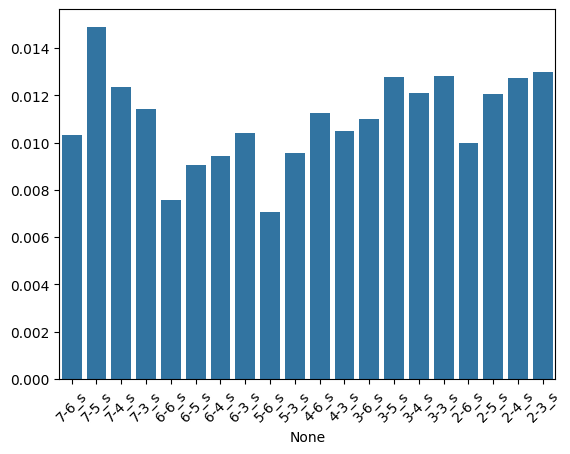

In [97]:
# errors by cells
by_cells = []
for i in y_val.columns:
    mae = mean_absolute_error(
        y_val[i], res_stck_straight_bag[i]    
    )
    by_cells.append(mae)

#average interval of prediction
str_stck_bag_intervals = ( ( ( ((res_stck_straight_bag.to_numpy() - y_val)**2).sum() / ( len(y_val) - 2) )**(1/2) )  * 1.96 ).to_numpy()
print(str_stck_bag_intervals, str_stck_bag_intervals.mean())

sns.barplot(x=res_stck_straight_bag.columns, y=by_cells)
plt.xticks(rotation=45)

<Axes: xlabel='4', ylabel='0'>

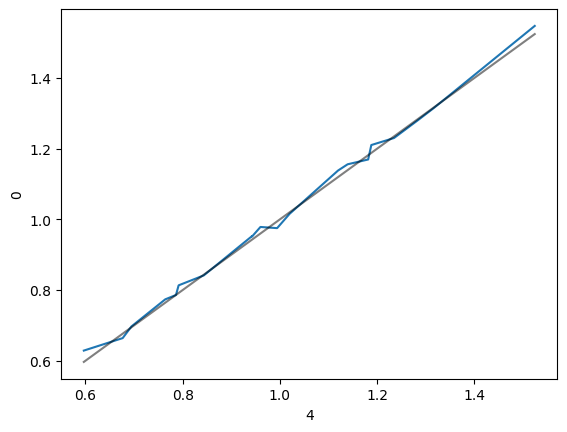

In [98]:
#average interval of prediction

fig, ax = plt.subplots()

str_stck_bag_lower = res_stck_straight_bag - str_stck_bag_intervals
str_stck_bag_upper = res_stck_straight_bag + str_stck_bag_intervals

sns.lineplot(x=y_val.iloc[0], y=res_stck_straight_bag.iloc[0], ax=ax)
sns.lineplot(x=y_val.iloc[0], y=y_val.iloc[0], ax=ax, color="black", alpha=0.5)

# ax.fill_between(y_test_mo["7-6_s"], rch_mo_int_lower, rch_mo_int_upper, alpha=0.2)


In [99]:
d.display(res_stck_straight_bag.iloc[0], dt="_s")

,6,5,4,3
7,0.663951,1.015584,1.169348,0.952793
6,0.841386,0.975110,1.314765,1.230095
5,0.785973,nan,nan,1.280574
4,1.210234,nan,nan,1.547292
3,0.773594,1.155778,0.951689,1.138083
2,0.697022,0.628633,0.978432,0.813275


In [100]:
d.display(y_val.iloc[0], dt="_s")

,6,5,4,3
7,0.676469,1.019903,1.181528,0.942797
6,0.843354,0.994229,1.316339,1.234700
5,0.786115,nan,nan,1.283922
4,1.188010,nan,nan,1.524204
3,0.764031,1.139299,0.942844,1.119552
2,0.694601,0.596557,0.959940,0.791606


In [101]:
from joblib import dump
dump(filename="stck_bag_non_unifor_v1.3.joblib", value=models_str_stck_bag)


['stck_bag_non_unifor_v1.3.joblib']

In [74]:
from main.permutations import Permutations

In [75]:
pind = 104
p = Permutations(df=df.loc[:,
    [
        "Name",
        *d.CORE_PARTS["burnup"]["ALL_CELLS"],
        *d.CORE_PARTS["fuel_type"]["ALL_CELLS"],
        *fuel_left_cols
    ]
], ind=pind)

In [76]:
p.df

,Name,7-6_b,7-5_b,7-4_b,7-3_b,6-6_b,6-5_b,6-4_b,6-3_b,5-6_b,...,4-6_l,4-3_l,3-6_l,3-5_l,3-4_l,3-3_l,2-6_l,2-5_l,2-4_l,2-3_l
104,120_fake_burn3_e1,29.52,140.76,140.55,172.26,99.799,16.5625,161.438,51.4365,105.629,...,235.108,205.02,165.2275,115.858,247.3245,215.3655,150.81,131.04,241.53,237.18


In [77]:
d.display(p.df.loc[pind, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy(), dt="burnup")

,6,5,4,3
7,29.520000,140.760000,140.550000,172.260000
6,99.799000,16.562500,161.438000,51.436500
5,105.629000,nan,nan,94.860000
4,29.892000,nan,nan,94.980000
3,99.772500,149.142000,17.675500,49.634500
2,149.190000,168.960000,58.470000,62.820000


In [78]:
d.display(p.df.loc[pind, d.CORE_PARTS["left"]["ALL_CELLS"]].to_numpy(), dt="burnup")

,6,5,4,3
7,270.480000,159.240000,159.450000,127.740000
6,165.201000,248.437500,103.562000,213.563500
5,159.371000,nan,nan,205.140000
4,235.108000,nan,nan,205.020000
3,165.227500,115.858000,247.324500,215.365500
2,150.810000,131.040000,241.530000,237.180000


In [79]:
df_perm = p.make_permutations(cells_from=["2-6", "7-4", "7-3", "7-6"], cells_to=["2-4", "2-5", "4-3", "5-3"])

Detected among six tubes [] Detected among eight tubes ['2-6', '7-3', '5-3', '2-5', '7-6', '7-4', '4-3', '2-4']


In [80]:
df_perm = df_perm.loc[:, [*d.CORE_PARTS["burnup"]["ALL_CELLS"], *fuel_left_cols]]
df_perm

,7-6_b,7-5_b,7-4_b,7-3_b,6-6_b,6-5_b,6-4_b,6-3_b,5-6_b,5-3_b,...,4-6_l,4-3_l,3-6_l,3-5_l,3-4_l,3-3_l,2-6_l,2-5_l,2-4_l,2-3_l
104,94.86,140.76,168.96,94.98,99.799,16.5625,161.438,51.4365,105.629,29.52,...,235.108,127.74,165.2275,115.858,247.3245,215.3655,241.53,159.45,150.81,237.18


In [84]:
perm_pred = validation_stacking_bagging(models_str_stck_bag, df_perm)
perm_pred

,7-6_s,7-5_s,7-4_s,7-3_s,6-6_s,6-5_s,6-4_s,6-3_s,5-6_s,5-3_s,4-6_s,4-3_s,3-6_s,3-5_s,3-4_s,3-3_s,2-6_s,2-5_s,2-4_s,2-3_s
0,0.877624,0.76204,0.707536,0.999006,0.828236,1.3153,0.799129,1.224783,0.933122,1.551263,1.160983,0.959177,0.845669,0.827535,1.35103,1.188195,0.953896,0.795123,0.768431,1.091424


In [82]:
d.display(df.loc[pind, d.CORE_PARTS["coef"]["ALL_CELLS"]].to_numpy(), dt="burnup")


,6,5,4,3
7,0.975777,0.760367,0.828397,0.703382
6,0.843657,1.279728,0.761998,1.223763
5,0.940597,nan,nan,1.295722
4,1.165640,nan,nan,1.318447
3,0.860237,0.807080,1.358968,1.246582
2,0.709241,0.722358,1.070489,1.127570


In [83]:
d.display(perm_pred.iloc[0], dt="_s")


,6,5,4,3
7,0.877624,0.762040,0.707536,0.999006
6,0.828236,1.315300,0.799129,1.224783
5,0.933122,nan,nan,1.551263
4,1.160983,nan,nan,0.959177
3,0.845669,0.827535,1.351030,1.188195
2,0.953896,0.795123,0.768431,1.091424


In [76]:
df_burnup_only = pd.read_excel("input_burnup.xlsx", sheet_name="default_burnup_only")

<Axes: ylabel='3-6_s'>

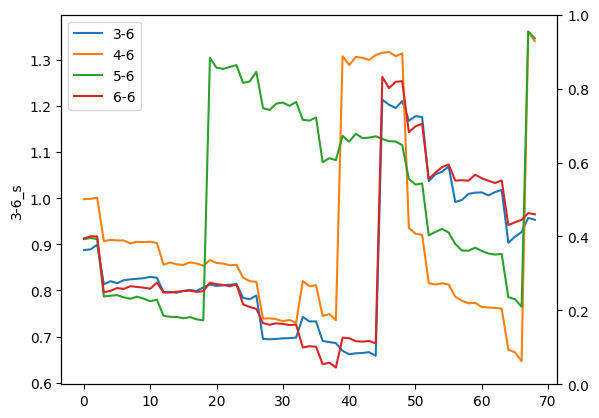

In [77]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
sns.lineplot(df_burnup_only["3-6_s"], ax=ax, label="3-6")
sns.lineplot(df_burnup_only["4-6_s"], ax=ax, label="4-6")
# sns.lineplot(df_burnup_only["4-6_b"], ax=ax2, color="black")
sns.lineplot(df_burnup_only["5-6_s"], ax=ax, label="5-6")
sns.lineplot(df_burnup_only["6-6_s"], ax=ax, label="6-6")
# sns.lineplot(df_burnup_only["5-6_b"], ax=ax2, color="grey")


# Simulation of burnup with fuel consumption

In [2650]:
from main.burnup import Burnup

In [2651]:
df_burnup = pd.read_excel("input_burnup.xlsx")

In [2652]:
d.display(df_burnup.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy())

,6,5,4,3
7,16.140000,57.120000,25.920000,150.180000
6,0.000000,76.000000,141.030000,157.360000
5,83.160000,nan,nan,116.160000
4,18.270000,nan,nan,115.410000
3,0.000000,129.060000,74.840000,149.960000
2,130.200000,32.430000,55.380000,146.820000


In [2653]:
percentage_cols =  d.CORE_PARTS["percentage"]["ALL_CELLS"]

df_burnup.loc[:, percentage_cols] = df_burnup.loc[:, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() / df_burnup.loc[:, d.CORE_PARTS["fuel_type"]["ALL_CELLS"]].to_numpy() * 100

In [2654]:
fuel_left_cols = d.CORE_PARTS["left"]["ALL_CELLS"]

df_burnup.loc[:, fuel_left_cols] = df_burnup.loc[:, d.CORE_PARTS["fuel_type"]["ALL_CELLS"]].to_numpy() - df_burnup.loc[:, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()

In [2655]:
U_per_step = 18.423

In [2656]:
loss_by_step = np.full((20,), 0.0)
for i in range(1, len(df_burnup)):
    
    loss = df_burnup.loc[i, d.CORE_PARTS["coef"]["ALL_CELLS"]].to_numpy()\
    * (df_burnup.loc[i, "loss_grams_per_step"] - U_per_step) / 20

    df_burnup.loc[i, d.CORE_PARTS["burnup"]["ALL_CELLS"]] = df_burnup.loc[i, d.CORE_PARTS["burnup"]["ALL_CELLS"]] - loss - loss_by_step
        
    loss_by_step = np.add(loss_by_step, loss)
# loss_by_step.append(loss)
    

In [2657]:
(df_burnup.loc[4, d.CORE_PARTS["burnup"]["ALL_CELLS"]] - df_burnup.loc[3, d.CORE_PARTS["burnup"]["ALL_CELLS"]]).sum()

18.413008349999924

In [2658]:
d.display(df_burnup.loc[0, d.CORE_PARTS["coef"]["ALL_CELLS"]].to_numpy())

,6,5,4,3
7,1.118000,1.052000,1.108000,0.752000
6,1.267000,1.158000,0.875000,0.725000
5,1.125000,nan,nan,1.079000
4,1.323000,nan,nan,1.040000
3,1.221000,0.872000,1.077000,0.705000
2,0.788000,1.053000,0.948000,0.715000


In [2659]:
d.display(df_burnup.loc[0, d.CORE_PARTS["percentage"]["ALL_CELLS"]].to_numpy())

,6,5,4,3
7,5.380000,19.040000,8.640000,50.060000
6,0.000000,28.679245,53.218868,59.381132
5,31.381132,nan,nan,38.720000
4,6.090000,nan,nan,38.470000
3,0.000000,48.701887,28.241509,56.588679
2,43.400000,10.810000,18.460000,48.940000


In [653]:
df_zero_step_raw = df_burnup.loc[:, [
        *d.CORE_PARTS["burnup"]["ALL_CELLS"], 
        *d.CORE_PARTS["left"]["ALL_CELLS"],
        *d.CORE_PARTS["fuel_type"]["ALL_CELLS"],
    ]
]

In [2664]:
df_zero_step = ct_mo.transform(df_zero_step_raw)
sim_zero_step = validation_stacking_bagging(models_str_stck_bag, df_zero_step_raw)

In [2665]:
sim_zero_step

,7-6_s,7-5_s,7-4_s,7-3_s,6-6_s,6-5_s,6-4_s,6-3_s,5-6_s,5-3_s,4-6_s,4-3_s,3-6_s,3-5_s,3-4_s,3-3_s,2-6_s,2-5_s,2-4_s,2-3_s
0,1.134984,1.061768,1.128299,0.754300,1.261375,1.163548,0.872343,0.716633,1.132321,1.076818,1.317372,1.031610,1.206563,0.872368,1.072447,0.693264,0.790102,1.050542,0.944420,0.709112
1,1.135445,1.062222,1.133559,0.751811,1.260895,1.162373,0.872834,0.717193,1.131284,1.081613,1.317686,1.037887,1.206086,0.874668,1.077797,0.694382,0.791464,1.057405,0.947134,0.709791
2,1.135807,1.058311,1.134042,0.752501,1.260456,1.162729,0.873485,0.716929,1.130841,1.081483,1.317798,1.038221,1.205445,0.875451,1.078036,0.694632,0.792145,1.057985,0.947906,0.710195
3,1.135049,1.058819,1.140969,0.755386,1.259149,1.164378,0.873951,0.717902,1.126751,1.082005,1.317206,1.038396,1.204919,0.875849,1.079428,0.695628,0.786162,1.057698,0.948668,0.710655
4,1.132033,1.057466,1.126382,0.749950,1.254827,1.160918,0.868148,0.713543,1.124609,1.091607,1.318860,1.038219,1.204941,0.874151,1.077772,0.698027,0.789858,1.062459,0.954591,0.718483
5,1.132140,1.058261,1.128014,0.750609,1.254517,1.161034,0.868942,0.713525,1.124127,1.071834,1.319127,1.037663,1.205168,0.874605,1.078168,0.698346,0.792528,1.063238,0.955508,0.718700
6,1.133005,1.063444,1.130464,0.755757,1.253760,1.161552,0.869867,0.715143,1.123885,1.072678,1.322319,1.036805,1.204673,0.868815,1.078532,0.699318,0.792762,1.063617,0.956123,0.719053
7,1.133316,1.064636,1.131125,0.758470,1.253320,1.162332,0.870362,0.715161,1.126241,1.069378,1.331738,1.037080,1.204727,0.869761,1.078911,0.700091,0.786955,1.064105,0.957072,0.719565
8,1.134463,1.066185,1.132816,0.759796,1.250530,1.164572,0.870686,0.715734,1.123181,1.073993,1.332101,1.040761,1.203343,0.869690,1.079375,0.706656,0.770566,1.064227,0.958456,0.719853


In [2667]:
d.display(sim_zero_step.iloc[0], dt="_s")


,6,5,4,3
7,1.134984,1.061768,1.128299,0.754300
6,1.261375,1.163548,0.872343,0.716633
5,1.132321,nan,nan,1.076818
4,1.317372,nan,nan,1.031610
3,1.206563,0.872368,1.072447,0.693264
2,0.790102,1.050542,0.944420,0.709112


In [2668]:
df_zero_step_raw.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]] = sim_zero_step

## 1st step of burnup simulation

In [2672]:
b1 = Burnup(df_zero_step_raw)
df_burnt_raw1 = b1.simulate_burnup("2.0833d", 0)

In [2674]:

sim_step1 = validation_stacking_bagging(models_str_stck_bag, df_burnt_raw1)

In [2675]:
d.display(df_burnup.loc[1, d.CORE_PARTS["coef"]["ALL_CELLS"]].to_numpy(), dt="_s")

,6,5,4,3
7,1.107000,1.046000,1.103000,0.756000
6,1.243000,1.154000,0.876000,0.733000
5,1.122000,nan,nan,1.088000
4,1.316000,nan,nan,1.056000
3,1.207000,0.874000,1.082000,0.715000
2,0.788000,1.053000,0.953000,0.727000


In [2676]:
d.display(sim_step1.iloc[0], dt="_s")


,6,5,4,3
7,1.135492,1.062297,1.133636,0.752348
6,1.260797,1.162269,0.872739,0.717065
5,1.131092,nan,nan,1.081728
4,1.317295,nan,nan,1.038008
3,1.206045,0.874535,1.077712,0.694341
2,0.790918,1.057046,0.947230,0.709964


In [2677]:
d.display(df_burnup.loc[1, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy())

,6,5,4,3
7,17.274078,58.164404,27.024099,150.865955
6,1.103350,77.003826,141.775313,157.966078
5,84.103997,nan,nan,117.204179
4,19.582959,nan,nan,116.424350
3,1.083543,129.795324,75.754211,150.546175
2,130.945784,33.474366,56.304901,147.476111


In [2678]:
d.display(df_burnt_raw1.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy())

,6,5,4,3
7,17.185552,58.098105,26.959394,150.874865
6,1.161984,77.071865,141.833606,158.020165
5,84.203098,nan,nan,117.151969
4,19.483568,nan,nan,116.360323
3,1.111491,129.863629,75.827942,150.598638
2,130.927845,33.397764,56.250004,147.473237


In [2679]:
burnup_mcu1 = (df_burnup.loc[1, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() - df_burnup.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()).sum()
burnup_sim1 = (df_burnt_raw1.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() - df_zero_step_raw.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()).sum()

print(
    "sum burnup on 1st step from MCU: ", burnup_mcu1
)
print(
    "sum burnup on 1st step: ", burnup_sim1
)
print(
    "total loss on prediction of 1st step:", (df_burnt_raw1.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() - df_burnup.loc[1, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()).sum() #+ burnup_mcu1 - burnup_sim1
)

print("error on cells: ", mean_absolute_error(
    df_burnt_raw1.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy(), 
    df_burnup.loc[1, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()
))

sum burnup on 1st step from MCU:  18.433005350000037
sum burnup on 1st step:  18.415043945899654
total loss on prediction of 1st step: -0.017961404100381495
error on cells:  0.05784900297435493


In [2680]:
df_burnt_raw1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]] = sim_step1

In [2681]:
df_burnt_raw1

,7-6_b,7-5_b,7-4_b,7-3_b,6-6_b,6-5_b,6-4_b,6-3_b,5-6_b,5-3_b,...,4-6_s,4-3_s,3-6_s,3-5_s,3-4_s,3-3_s,2-6_s,2-5_s,2-4_s,2-3_s
0,17.185552,58.098105,26.959394,150.874865,1.161984,77.071865,141.833606,158.020165,84.203098,117.151969,...,1.317295,1.038008,1.206045,0.874535,1.077712,0.694341,0.790918,1.057046,0.94723,0.709964


## 2nd step of burnup simulation

In [2683]:
b2 = Burnup(df_burnt_raw1)
df_burnt_raw2 = b2.simulate_burnup("2.0833d", 0)

In [2685]:

sim_step2 = validation_stacking_bagging(models_str_stck_bag, df_burnt_raw2)

In [2686]:
d.display(df_burnup.loc[2, d.CORE_PARTS["coef"]["ALL_CELLS"]].to_numpy(), dt="_s")

,6,5,4,3
7,1.112000,1.051000,1.109000,0.760000
6,1.245000,1.155000,0.878000,0.735000
5,1.121000,nan,nan,1.085000
4,1.314000,nan,nan,1.052000
3,1.204000,0.873000,1.080000,0.712000
2,0.787000,1.051000,0.952000,0.723000


In [2688]:
d.display(sim_step2.iloc[0], dt="_s")

,6,5,4,3
7,1.135819,1.058357,1.134054,0.752523
6,1.260270,1.162455,0.873242,0.716731
5,1.130467,nan,nan,1.081699
4,1.317821,nan,nan,1.038479
3,1.205329,0.875225,1.077964,0.694571
2,0.792277,1.058126,0.948202,0.710387


In [2689]:
d.display(df_burnup.loc[2, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy())

,6,5,4,3
7,18.343291,59.174209,28.093342,151.608583
6,2.211273,78.002623,142.506797,158.568949
5,85.073124,nan,nan,118.243655
4,20.860214,nan,nan,117.434146
3,2.131864,130.526856,76.703735,151.149268
2,131.718150,34.514172,57.255667,148.189097


In [2690]:
d.display(df_burnt_raw2.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy())

,6,5,4,3
7,18.231572,59.076697,28.003704,151.567931
6,2.323435,78.142551,142.637577,158.680728
5,85.245064,nan,nan,118.148462
4,20.697066,nan,nan,117.316541
3,2.222504,130.669254,76.820734,151.238268
2,131.656442,34.371518,57.122596,148.127258


In [2691]:
burnup_mcu2 = (df_burnup.loc[2, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() - df_burnup.loc[1, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()).sum()
burnup_sim2 = (df_burnt_raw2.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() - df_burnt_raw1.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()).sum()

print(
    "sum burnup on 2nd step from MCU: ", burnup_mcu2
)
print(
    "sum burnup on 2nd step: ", burnup_sim2
)
print(
    "total loss on prediction of 2st step:", (df_burnt_raw2.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() - df_burnup.loc[2, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()).sum() #+ burnup_mcu1 - burnup_sim1 + burnup_mcu2 - burnup_sim1
)




sum burnup on 2nd step from MCU:  18.4360097
sum burnup on 2nd step:  18.444858768957545
total loss on prediction of 2st step: -0.009112335142838823


In [2692]:
df_burnt_raw2.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]] = sim_step2

In [2693]:
df_burnt_raw2

,7-6_b,7-5_b,7-4_b,7-3_b,6-6_b,6-5_b,6-4_b,6-3_b,5-6_b,5-3_b,...,4-6_s,4-3_s,3-6_s,3-5_s,3-4_s,3-3_s,2-6_s,2-5_s,2-4_s,2-3_s
0,18.231572,59.076697,28.003704,151.567931,2.323435,78.142551,142.637577,158.680728,85.245064,118.148462,...,1.317821,1.038479,1.205329,0.875225,1.077964,0.694571,0.792277,1.058126,0.948202,0.710387


In [676]:
1.498E4/1000*24

359.52

## 3d step of burnup simulation

In [677]:
b3 = Burnup(df_burnt_raw2)
df_burnt_raw3 = b3.simulate_burnup("2.0833d", 0)

In [678]:
df_burnt = ct_mo.transform(df_burnt_raw3)
sim_step3 = rch_ridge.predict(df_burnt)

In [679]:
d.display(df_burnup.loc[3, d.CORE_PARTS["coef"]["ALL_CELLS"]].to_numpy(), dt="_s")

,6,5,4,3
7,1.117000,1.051000,1.110000,0.757000
6,1.246000,1.157000,0.878000,0.732000
5,1.122000,nan,nan,1.085000
4,1.314000,nan,nan,1.051000
3,1.204000,0.870000,1.082000,0.712000
2,0.786000,1.048000,0.953000,0.725000


In [680]:
d.display(sim_step3[0], dt="_s")

,6,5,4,3
7,1.124537,1.066551,1.125371,0.754706
6,1.250313,1.161722,0.872307,0.723453
5,1.123669,nan,nan,1.072550
4,1.313953,nan,nan,1.030997
3,1.211431,0.872066,1.072202,0.698377
2,0.792978,1.061946,0.952674,0.718200


In [681]:
d.display(df_burnup.loc[3, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy())

,6,5,4,3
7,19.447315,60.218586,29.197403,152.324533
6,3.284607,78.976433,143.272099,159.195033
5,86.027121,nan,nan,119.287850
4,22.173184,nan,nan,118.418523
3,3.185422,131.262202,77.627947,151.755459
2,132.463945,35.558565,58.180568,148.875219


In [682]:
d.display(df_burnt_raw3.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy())

,6,5,4,3
7,19.250244,60.066346,29.028063,152.262914
6,3.463390,79.216779,143.440796,159.354911
5,86.274071,nan,nan,119.123635
4,21.908168,nan,nan,118.258423
3,3.353583,131.467008,77.804787,151.882722
2,132.389431,35.361639,58.006465,148.798867


In [683]:
burnup_mcu3 = (df_burnup.loc[3, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() - df_burnup.loc[2, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()).sum()
burnup_sim3 = (df_burnt_raw3.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() - df_burnt_raw2.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()).sum()

print(
    "sum burnup on 3d step from MCU: ", burnup_mcu3
)
print(
    "sum burnup on 3d step: ", burnup_sim3
)
print(
    "total loss on prediction of 3d step:", (df_burnt_raw3.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() - df_burnup.loc[3, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()).sum() #+ burnup_mcu1 - burnup_sim1 + burnup_mcu2 - burnup_sim1
)

sum burnup on 3d step from MCU:  18.422999999999977
sum burnup on 3d step:  18.424080209999993
total loss on prediction of 3d step: -0.019774420000066684


In [684]:
df_burnt_raw3.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]] = sim_step3

In [685]:
df_burnt_raw3

,7-6_b,7-5_b,7-4_b,7-3_b,6-6_b,6-5_b,6-4_b,6-3_b,5-6_b,5-3_b,...,4-6_s,4-3_s,3-6_s,3-5_s,3-4_s,3-3_s,2-6_s,2-5_s,2-4_s,2-3_s
0,19.250244,60.066346,29.028063,152.262914,3.46339,79.216779,143.440796,159.354911,86.274071,119.123635,...,1.313953,1.030997,1.211431,0.872066,1.072202,0.698377,0.792978,1.061946,0.952674,0.7182
